In [1]:
include("../modules/generate_raw_data.jl")
include("../modules/process_raw_data.jl")
include("../modules/geometry.jl")
include("../modules/scene.jl")
#include("../inputs/input_parameters_nadirlooking.jl")
include("../inputs/input_parameters_slantlooking.jl")
include("../modules/range_spread_function.jl") # as RSF
include("../modules/orbits.jl")
include("../modules/sync.jl")
include("../modules/error_sources.jl")
include("../modules/performance_metrics.jl")
using NCDatasets
using Statistics

## RANGE SPREAD FUNCTION (matched filter output)

In [2]:
if enable_fast_time # matched filter gain is included in Srx
    Srx,MF,ft,t_rx=RSF.ideal_RSF(pulse_length,Δt,bandwidth,Trx) # Srx: RX window with MF centered, MF: ideal matched filter output (range spread function, RSF) for LFM pulse, ft: fast-time axis for MF, t_rx: RX window
    # Srx,MF,ft,t_rx=RSF.non_ideal_RSF(pulse_length,Δt,bandwidth,Trx,SFR,window_type) # TODO non-ideal RSF for LFM pulse with system complex frequency response (SFR) and fast-time windowing
end

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.09836642022447853, 0.18714839911685457, 0.2577613560982583, 0.3034462268375404, 0.3198995665901649, 0.3056577142598402, 0.2622030514190751, 0.19378770156352018, 0.10699701832589589  …  0.10699701832589589, 0.19378770156349404, 0.26220305141906247, 0.30565771425983035, 0.31989956659016505, 0.3034462268375404, 0.2577613560982648, 0.18714839911685457, 0.09836642022448909, 0.0], -1.0e-5:1.0e-8:1.0e-5, -0.00015:1.0e-8:0.00014999000000000005)

## PLATFORM LOCATIONS

In [3]:
orbit_dataset=Dataset("../inputs/"*orbit_filename) # Read orbits data in NetCDF format
t12_orbits=orbit_dataset["time"][1:2] # first two time samples
dt_orbits=t12_orbits[2]-t12_orbits[1] # time resolution of orbits (s)
orbit_time_index=(Int(round(SAR_start_time/dt_orbits))+1:1:Int(round((SAR_start_time+SAR_duration)/dt_orbits))+1) # index range for orbit times for time interval of interest
orbit_time=orbit_dataset["time"][orbit_time_index] # read in time data
orbit_pos=orbit_dataset["position"][:,:,orbit_time_index] # read in position data #TODO convert ECI to ECEF?
slow_time=(SAR_start_time:1/fp:SAR_start_time+SAR_duration) # create slow time axis
orbit_pos_interp=Orbits.interp_orbit(orbit_time,orbit_pos,slow_time) # interpolate orbit to slow time
p_xyz=1e3*orbit_pos_interp # convert km to m
Np=size(orbit_pos)[2] # number of platforms
Nst=size(slow_time)[1] # number of slow-time samples (pulses processed)

10

## TARGET LOCATIONS

In [4]:
t_geo_grid=Scene.form3Dgrid_for(t_θ,t_ϕ,t_h) # using 3 nested for loops
#t_geo_grid=Scene.form3Dgrid_array(t_θ,t_ϕ,t_h) # using array processing
t_xyz_grid=Geometry.geo_to_xyz(t_geo_grid,earth_radius,earth_eccentricity)

3×1 Array{Float64,2}:
      6.330910069865125e6
      0.0                
 772134.2170040606       

## GENERATE RAW DATA

In [8]:
ref_range=Generate_Raw_Data.distance(mean(t_xyz_grid,dims=2),mean(mean(p_xyz,dims=2),dims=3)) # reference range
#rawdata=Generate_Raw_Data.main(t_xyz_grid,p_xyz_grid,mode,tx_el,fc) # without fasttime, without slowtime TODO no longer working, delete?
#rawdata=Generate_Raw_Data.main_RSF(t_xyz_grid,p_xyz,mode,tx_el,fc,Srx,t_rx,ref_range) # with fasttime, without slowtime #TODO no longer working, delete?
if enable_fast_time # with fastime and slowtime; matched filter gain is included in Srx
    rawdata=Generate_Raw_Data.main_RSF_slowtime(t_xyz_grid,p_xyz,mode,tx_el,fc,Srx,t_rx,ref_range) # rawdata is a: 3D array of size Nst x Np x Nft (SAR/SIMO), 4D array of size Nst x Np(RX) x Np(TX) x Nft (MIMO)
else # without fastime, with slowtime; matched filter gain is included inside the function
    rawdata=Generate_Raw_Data.main_noRSF_slowtime(t_xyz_grid,p_xyz,mode,tx_el,fc) # rawdata is a: 2D array of size Nst x Np (SAR/SIMO), 3D array of size Nst x Np(RX) x Np(TX) (MIMO)
end
if !enable_fast_time;SNR=SNR*pulse_length*bandwidth;end # SNR increases after matched filter
if enable_thermal_noise;rawdata=Error_Sources.random_noise(rawdata,SNR,enable_fast_time,mode);end # adding random noise based on SNR after range (fast-time) processing

## IMAGE SCENE

In [6]:
Ns_θ=length(s_θ)
Ns_ϕ=length(s_ϕ)
Ns_h=length(s_h)
s_geo_grid=Scene.form3Dgrid_for(s_θ,s_ϕ,s_h) # using 3 nested for loops
#s_geo_grid=Scene.form3Dgrid_array(s_θ,s_ϕ,s_h) # using array processing
s_xyz_grid=Geometry.geo_to_xyz(s_geo_grid,earth_radius,earth_eccentricity)

3×3136441 Array{Float64,2}:
   6.33088e6    6.33088e6    6.33088e6  …   6.33094e6   6.33094e6   6.33094e6
 -88.3958     -88.3958     -88.3958        88.3965     88.3966     88.3966   
   7.72109e5    7.72109e5    7.72109e5      7.7216e5    7.7216e5    7.7216e5 

## PROCESS RAW DATA TO GENERATE IMAGE

In [7]:
if enable_fast_time # with fastime, with slowtime
    image_1xN=Process_Raw_Data.main_RSF_slowtime(rawdata,s_xyz_grid,p_xyz,mode,tx_el,fc,t_rx,ref_range)
else # without fastime, with slowtime
    image_1xN=Process_Raw_Data.main_noRSF_slowtime(rawdata,s_xyz_grid,p_xyz,mode,tx_el,fc)
end
image_3D=Scene.convert_image_1xN_to_3D(image_1xN,Ns_θ,Ns_ϕ,Ns_h)

161×161×121 Array{Float64,3}:
[:, :, 1] =
 17.8472   29.313    42.2732   56.6505   …   72.908     52.3508    32.7819  
 22.1212   32.967    45.2724   59.0184       73.1955    52.4601    31.3372  
  9.87679  20.5911   32.7921   46.4711       86.9761    66.9367    46.5953  
 15.2595   16.3309   23.1637   33.9462       94.9984    74.9376    54.5238  
 16.1291   20.6389   28.565    39.1965      115.148     94.3471    73.015   
  8.52401   8.71632  16.8265   28.2056   …  127.994    103.748     83.1269  
 20.0052   11.7631    6.50304  14.0485      170.231    151.086    131.337   
 38.3454   30.0307   20.21      8.81799     176.277    159.56     142.073   
 27.5123   20.3751   11.9083    3.75146     161.845    146.214    129.696   
 42.608    35.6078   27.1351   17.0921      170.015    155.349    139.76    
 56.6999   51.2689   44.3471   35.9017   …  170.22     155.475    139.826   
 40.9633   44.2895   39.3798   33.5101      195.885    180.305    163.693   
 54.6956   49.5227   43.0045   35.

## PERFORMANCE METRICS

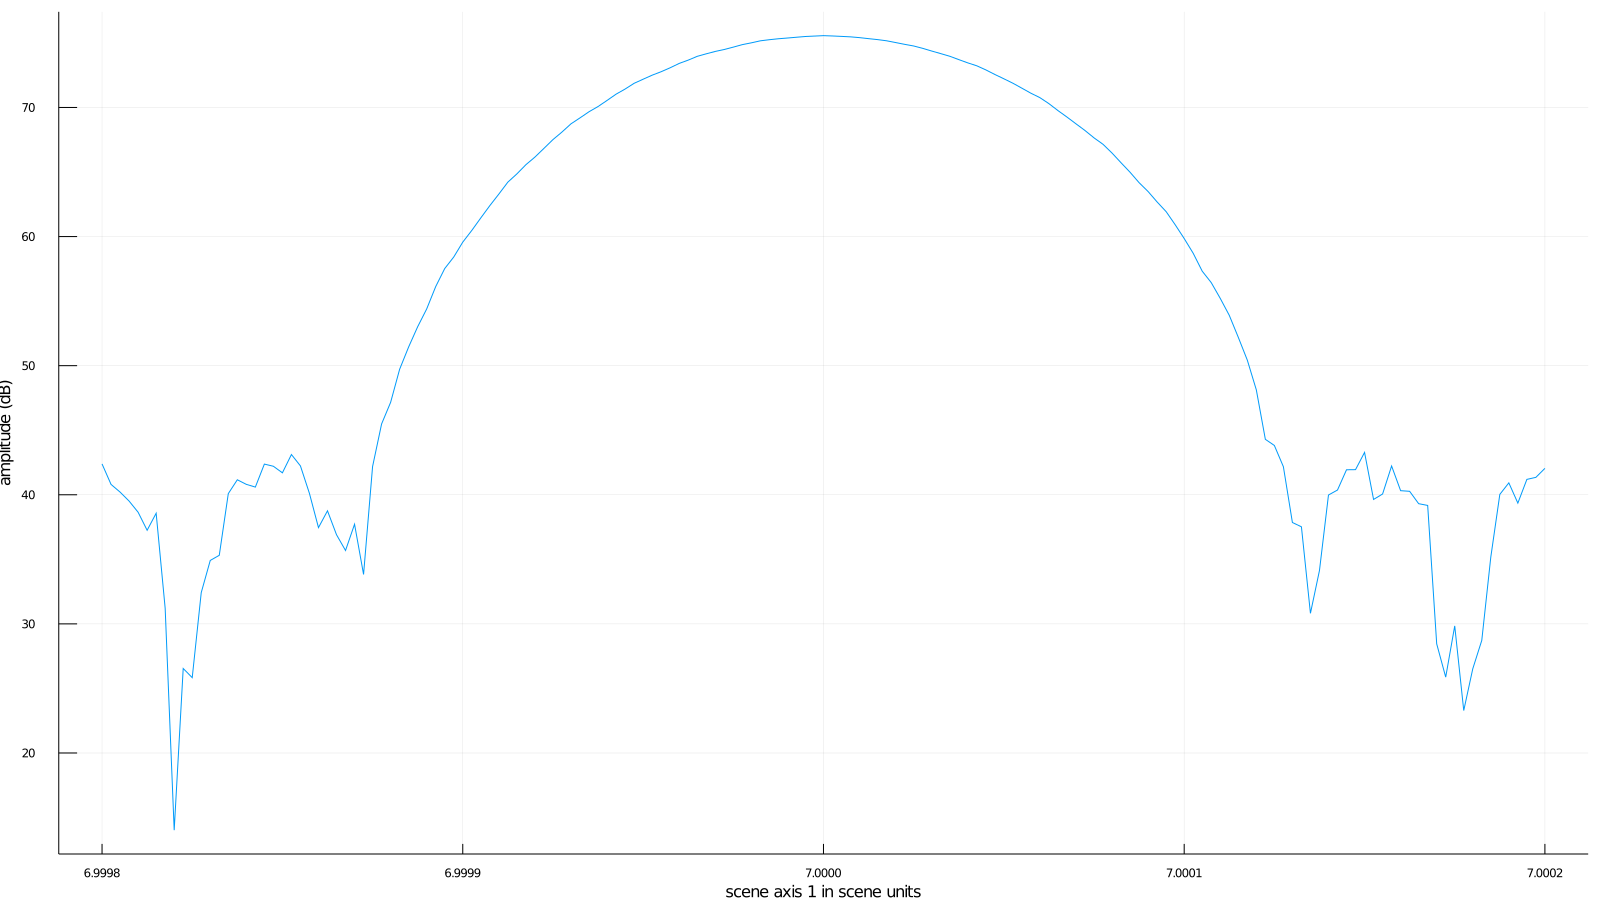

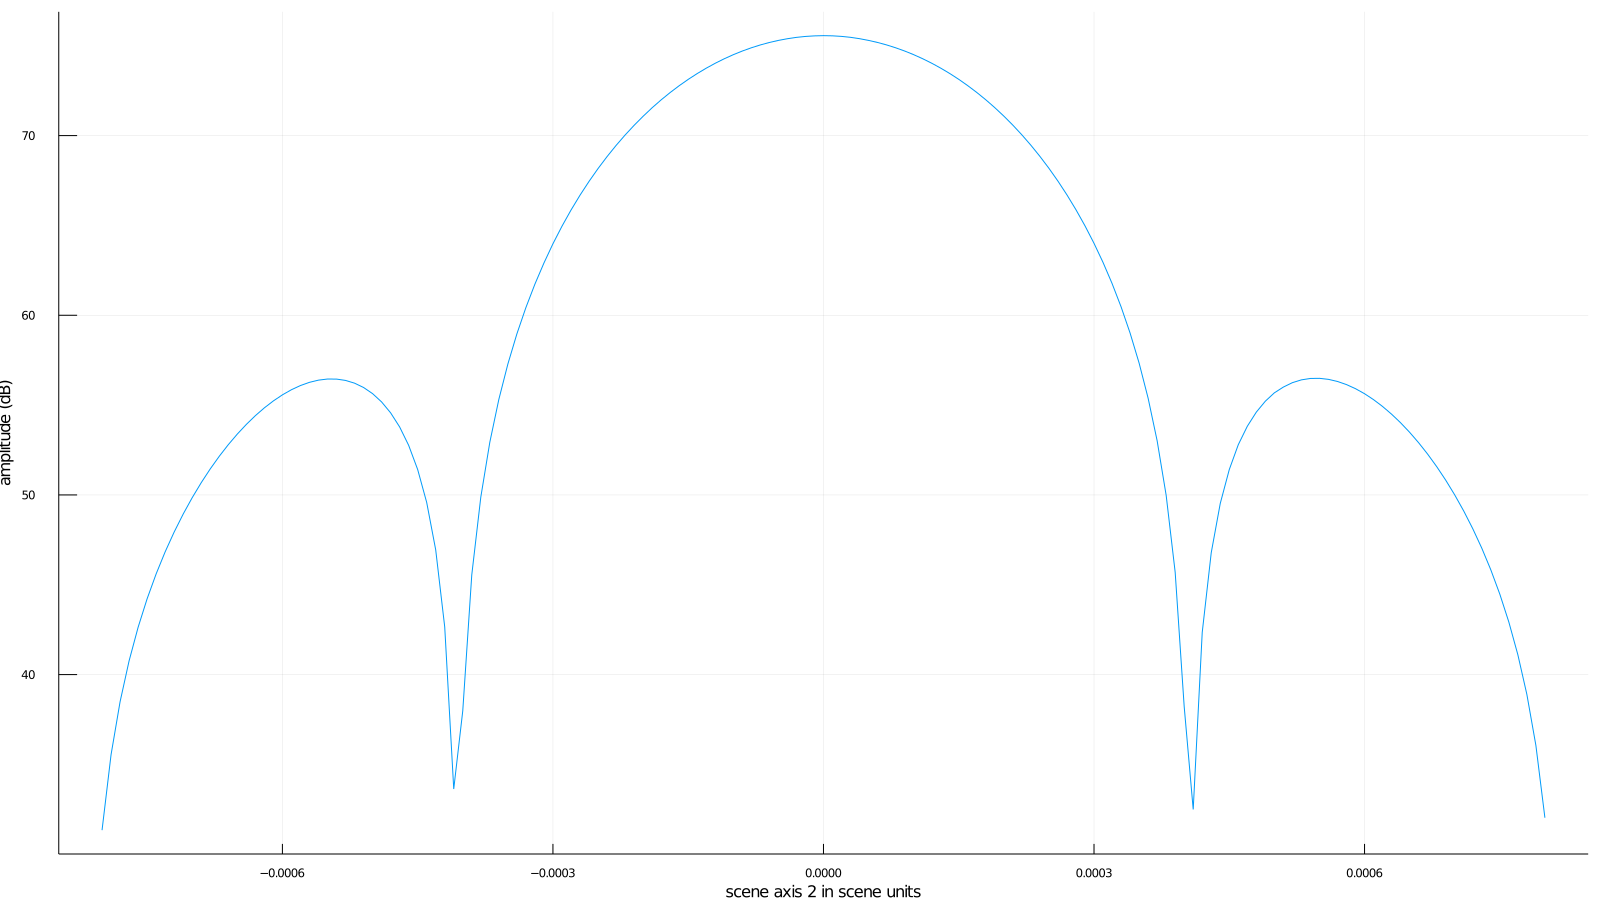

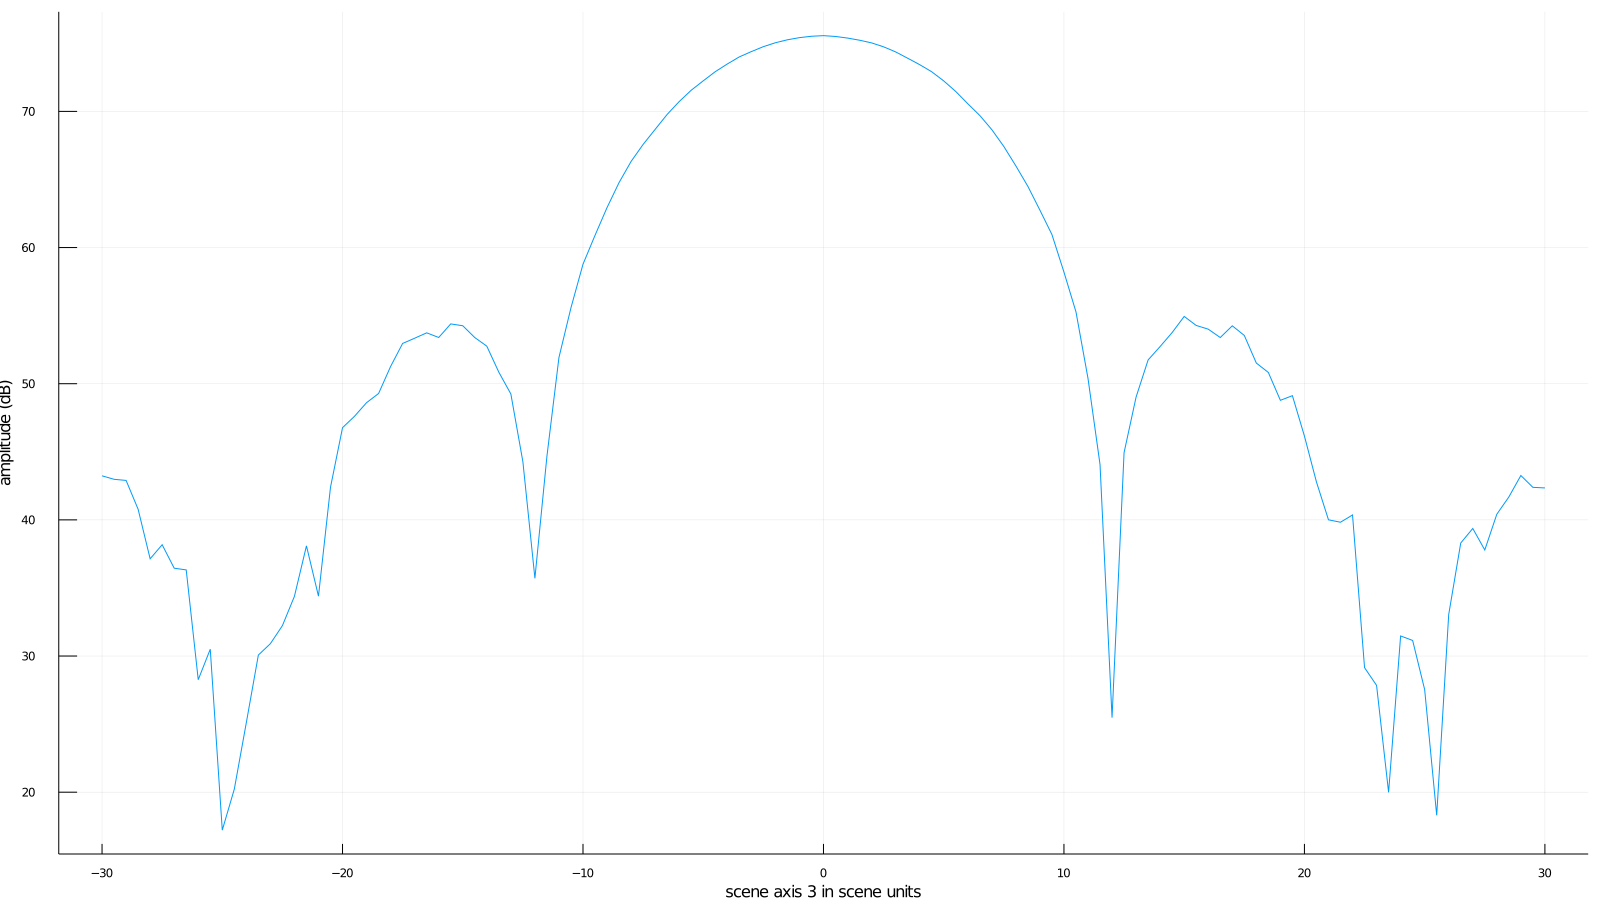

([9.50000000301543e-5, 0.0003400000000000009, 10.0], [32.281304555715494, 19.073089831791425, 20.622630795047527], [-5.026921372611442, -3.939427560793659, -4.971497501988671], [0.0, 0.0, 0.0])

In [9]:
if size(t_xyz_grid)[2]==1 # PSF related performance metrics are calculated when there is only one point target
    target_index1=findall(t_θ .==s_θ)
    target_index2=findall(t_ϕ .==s_ϕ)
    target_index3=findall(t_h .==s_h)
    if isempty(target_index1) || isempty(target_index2) || isempty(target_index3)
        show("PSF related performance metrics cannot be calculated since target is not inside the scene!")
        PSF_metrics=false
    else
        PSF_metrics=true
        target_location=[t_θ t_ϕ t_h] # point target location
        resolutions,PSLRs,ISLRs,loc_errors=Performance_Metrics.PSF_metrics(image_3D,res_dB,target_location,s_θ,s_ϕ,s_h,PSF_peak_target) # resolutions in each of the 3 axes
    end
else
    PSF_metrics=false
    show("PSF related performance metrics cannot be calculated since there are more than 1 targets!")
end

In [10]:
if PSF_metrics
    println("Resolutions: ",round.(resolutions,digits=8)," in scene axes units")
    println("Location Errors: ",round.(loc_errors,digits=8)," in scene axes units")
    println("PSLRs: ",round.(PSLRs,digits=2)," dB")
    println("ISLRs: ",round.(ISLRs,digits=2)," dB")
    println("PSF Peak Amplitude: ",round(maximum(20*log10.(image_3D)),digits=2)," dB")
end

Resolutions: [9.5e-5, 0.00034, 10.0] in scene axes units
Location Errors: [0.0, 0.0, 0.0] in scene axes units
PSLRs: [32.28, 19.07, 20.62] dB
ISLRs: [-5.03, -3.94, -4.97] dB
PSF Peak Amplitude: 75.56 dB


## PLOTS

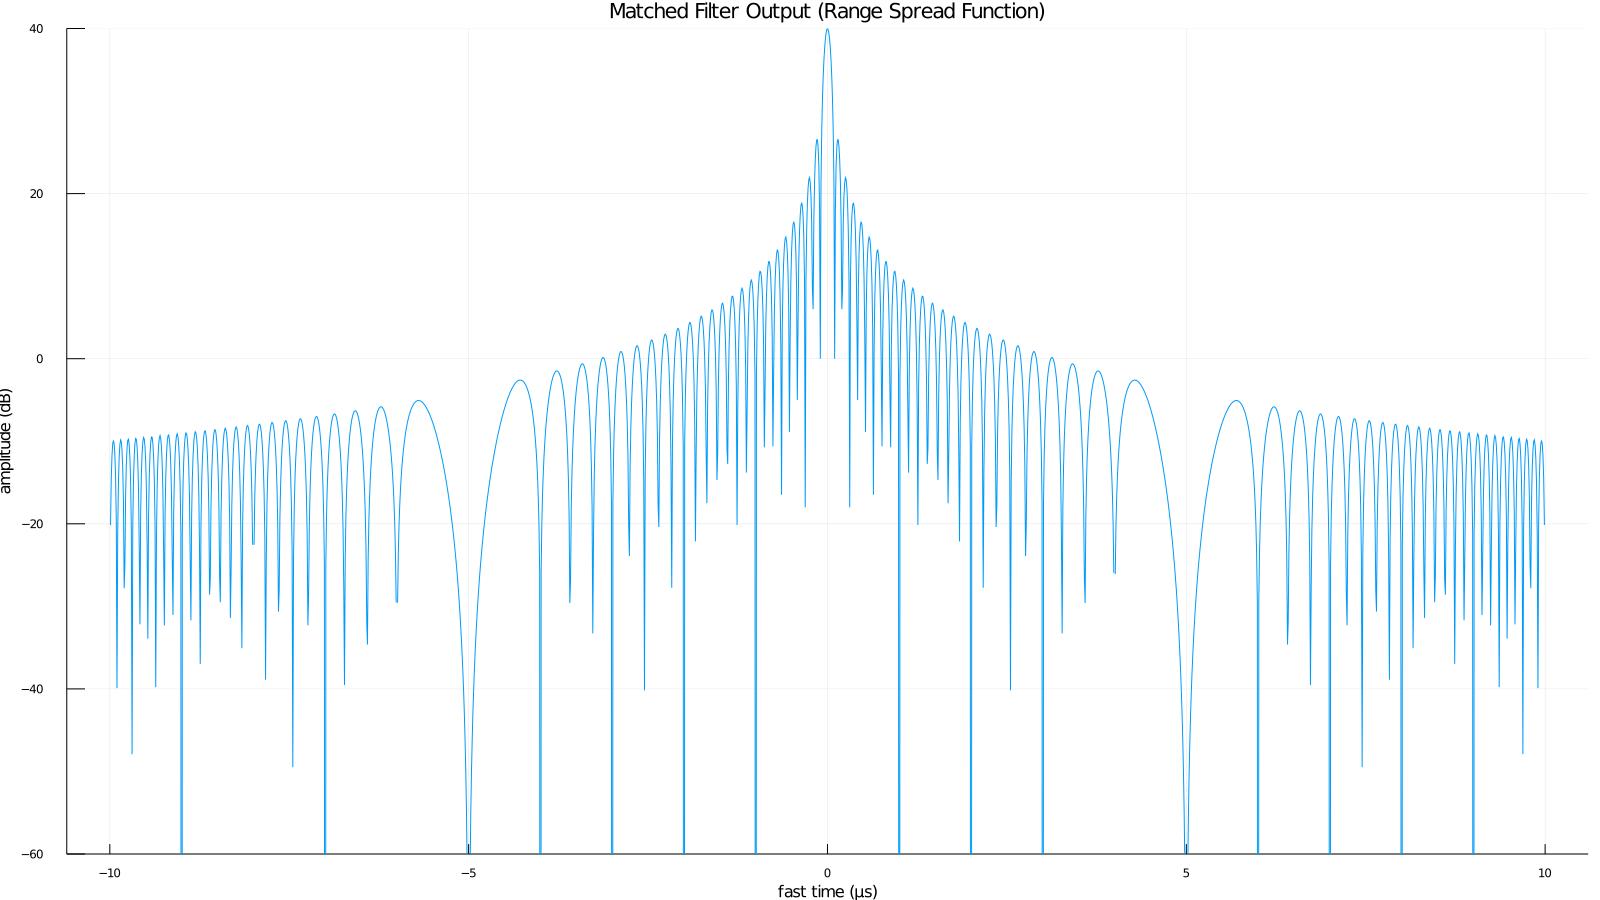

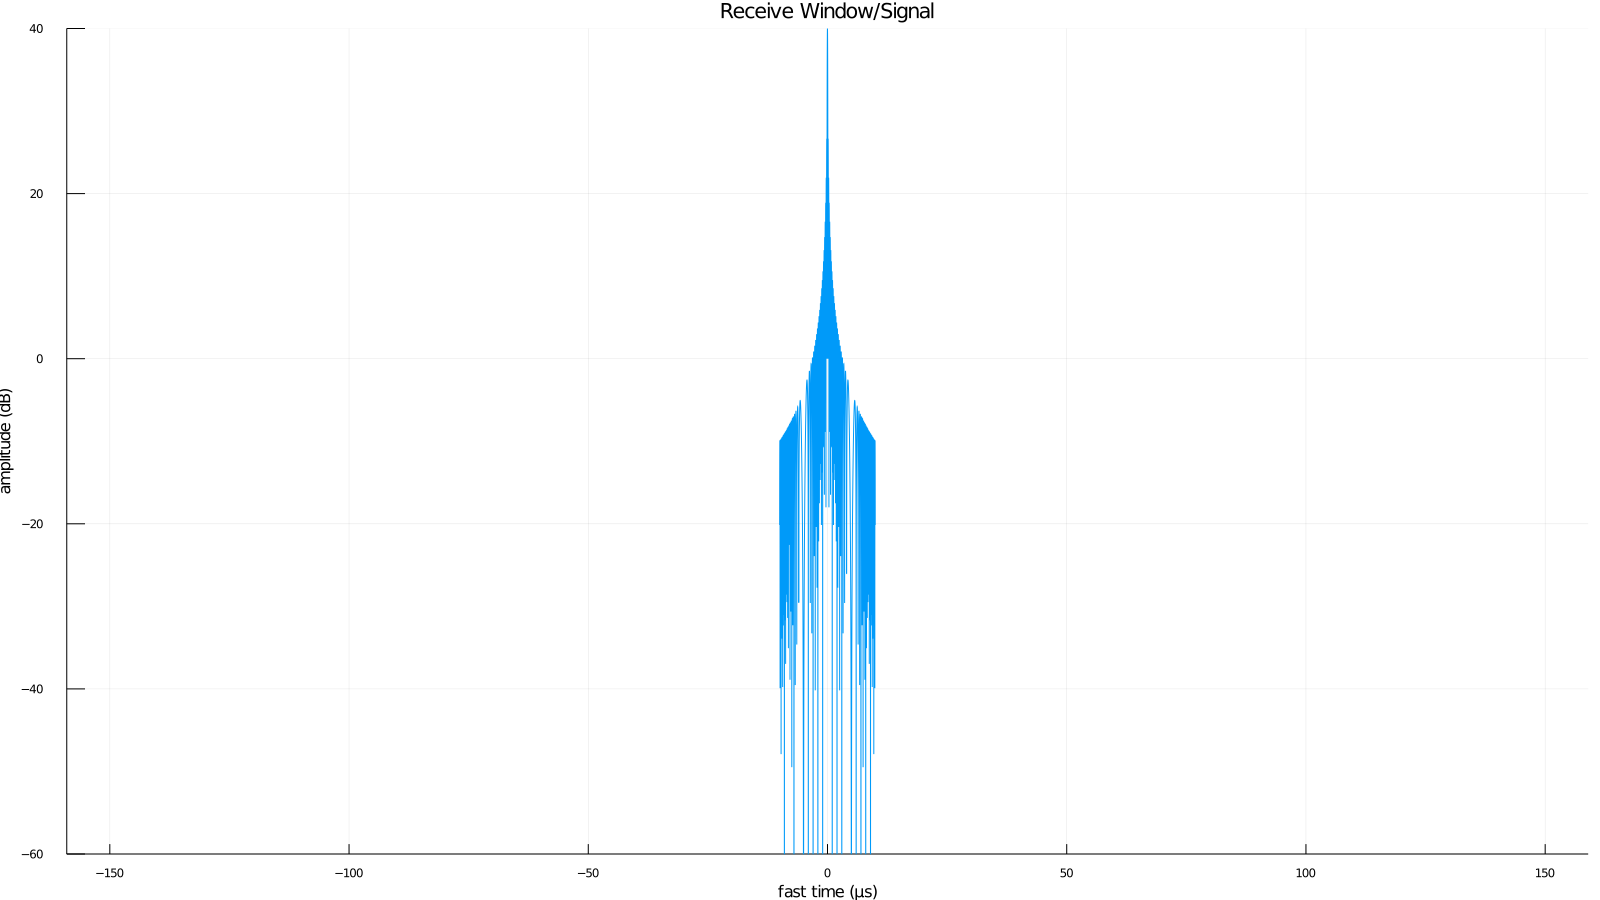

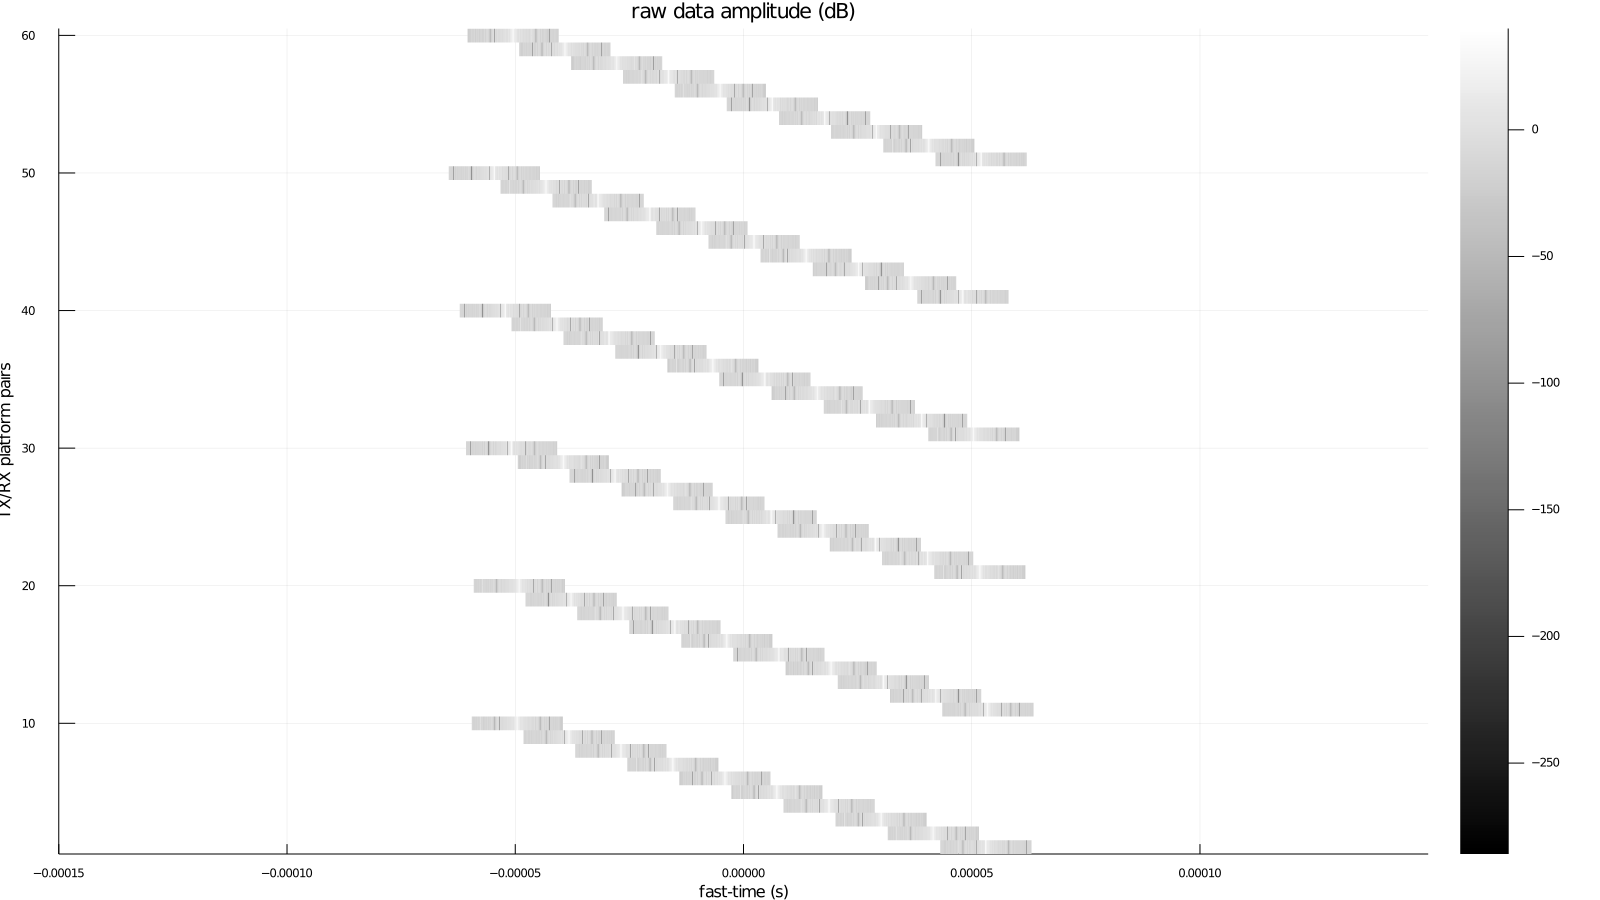

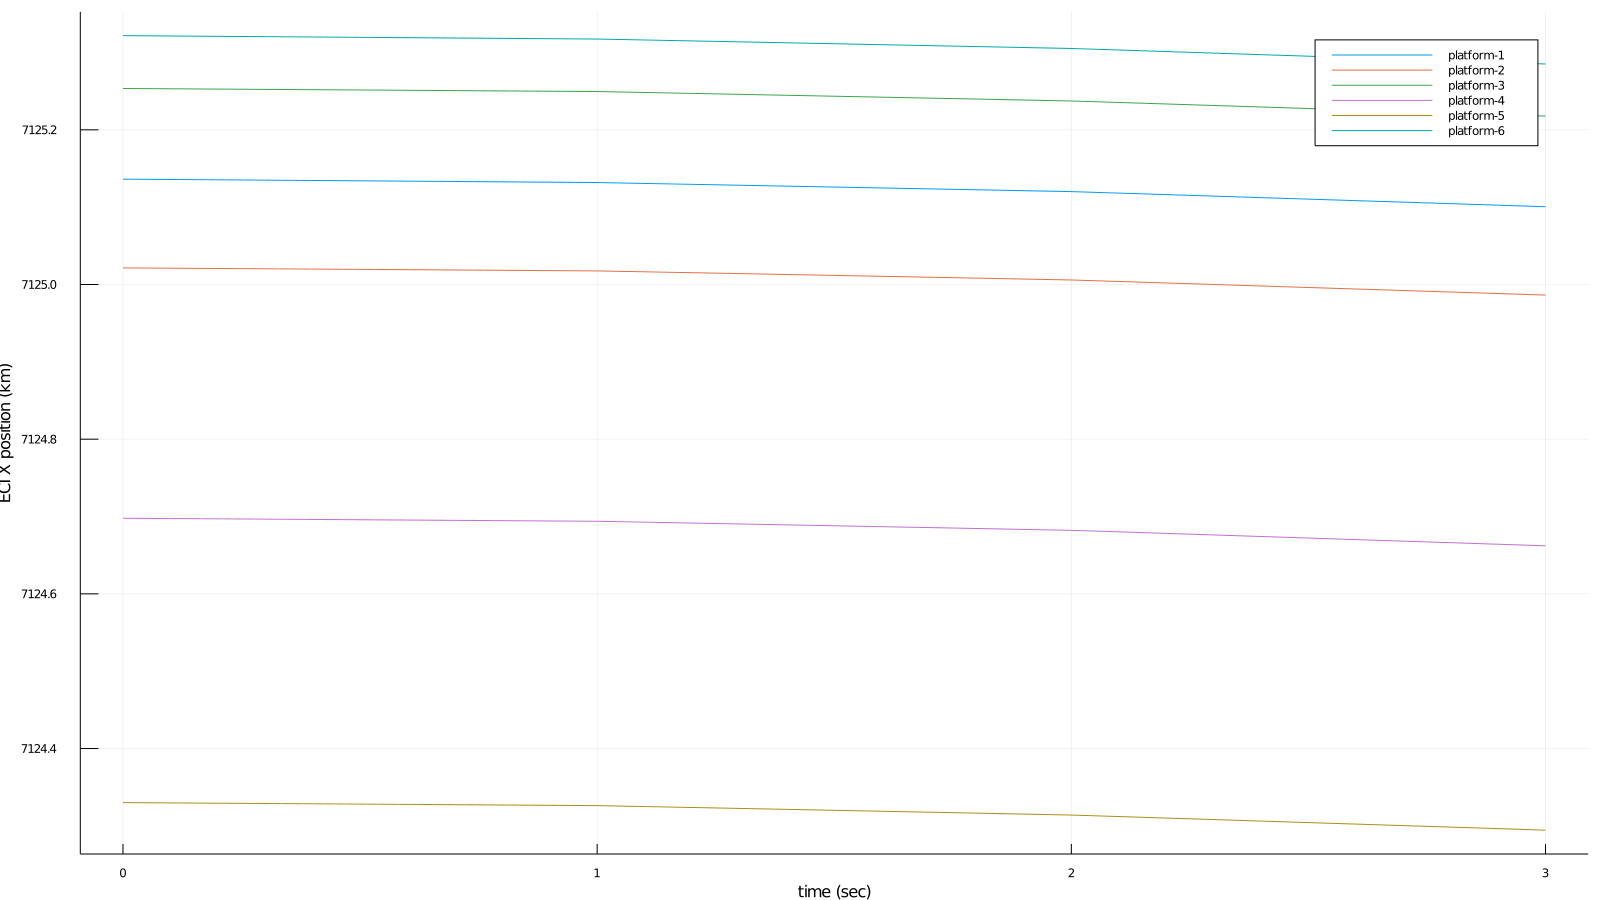

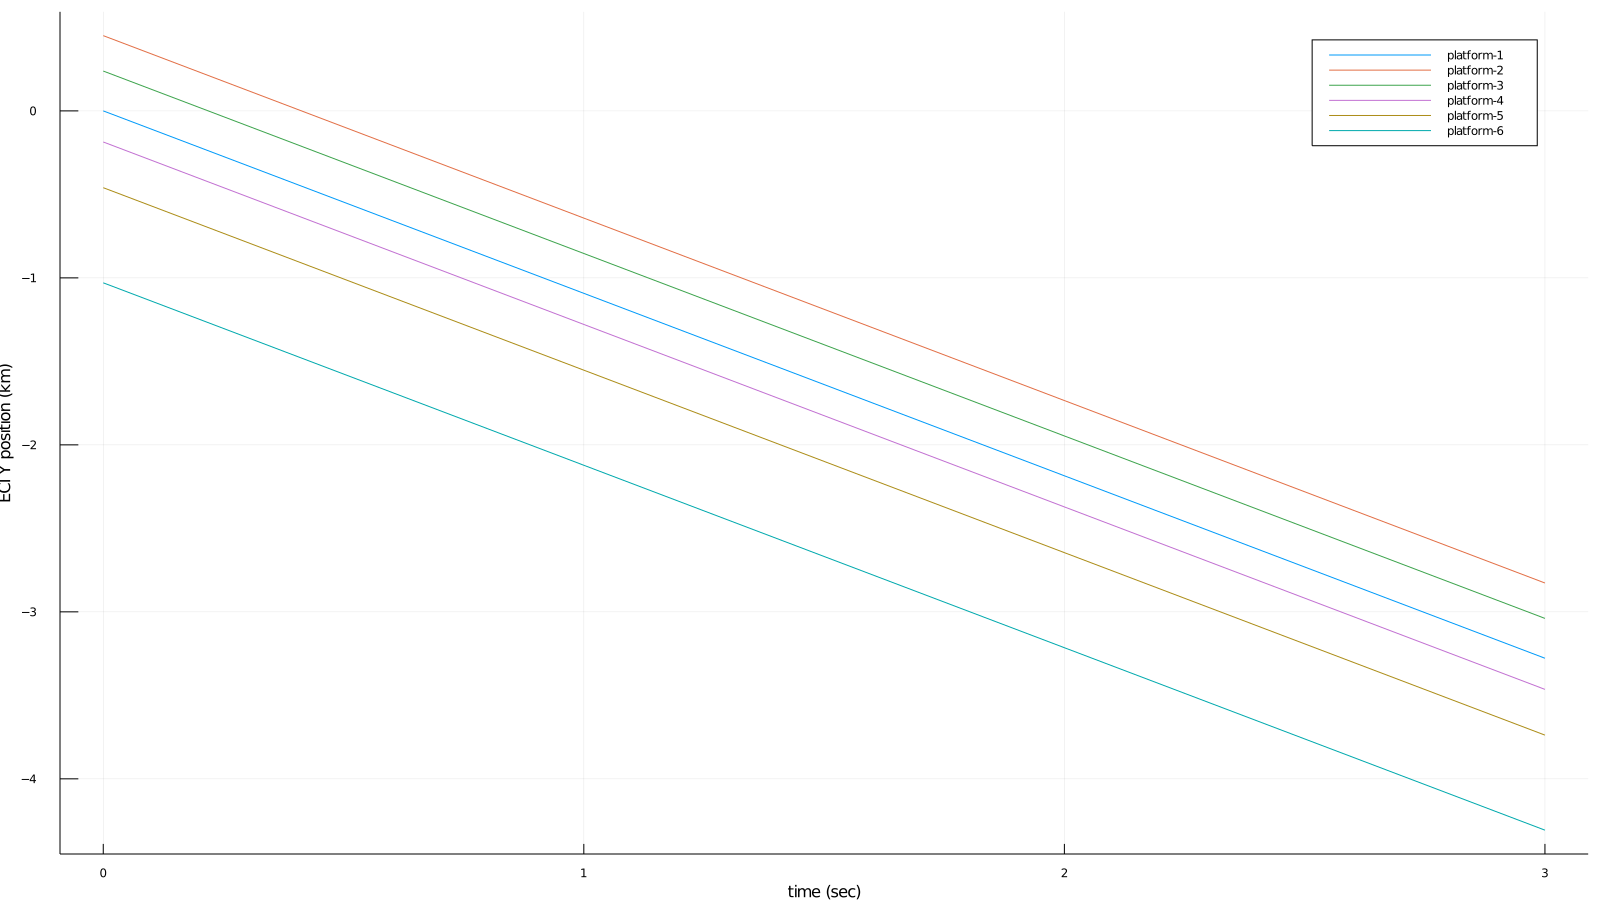

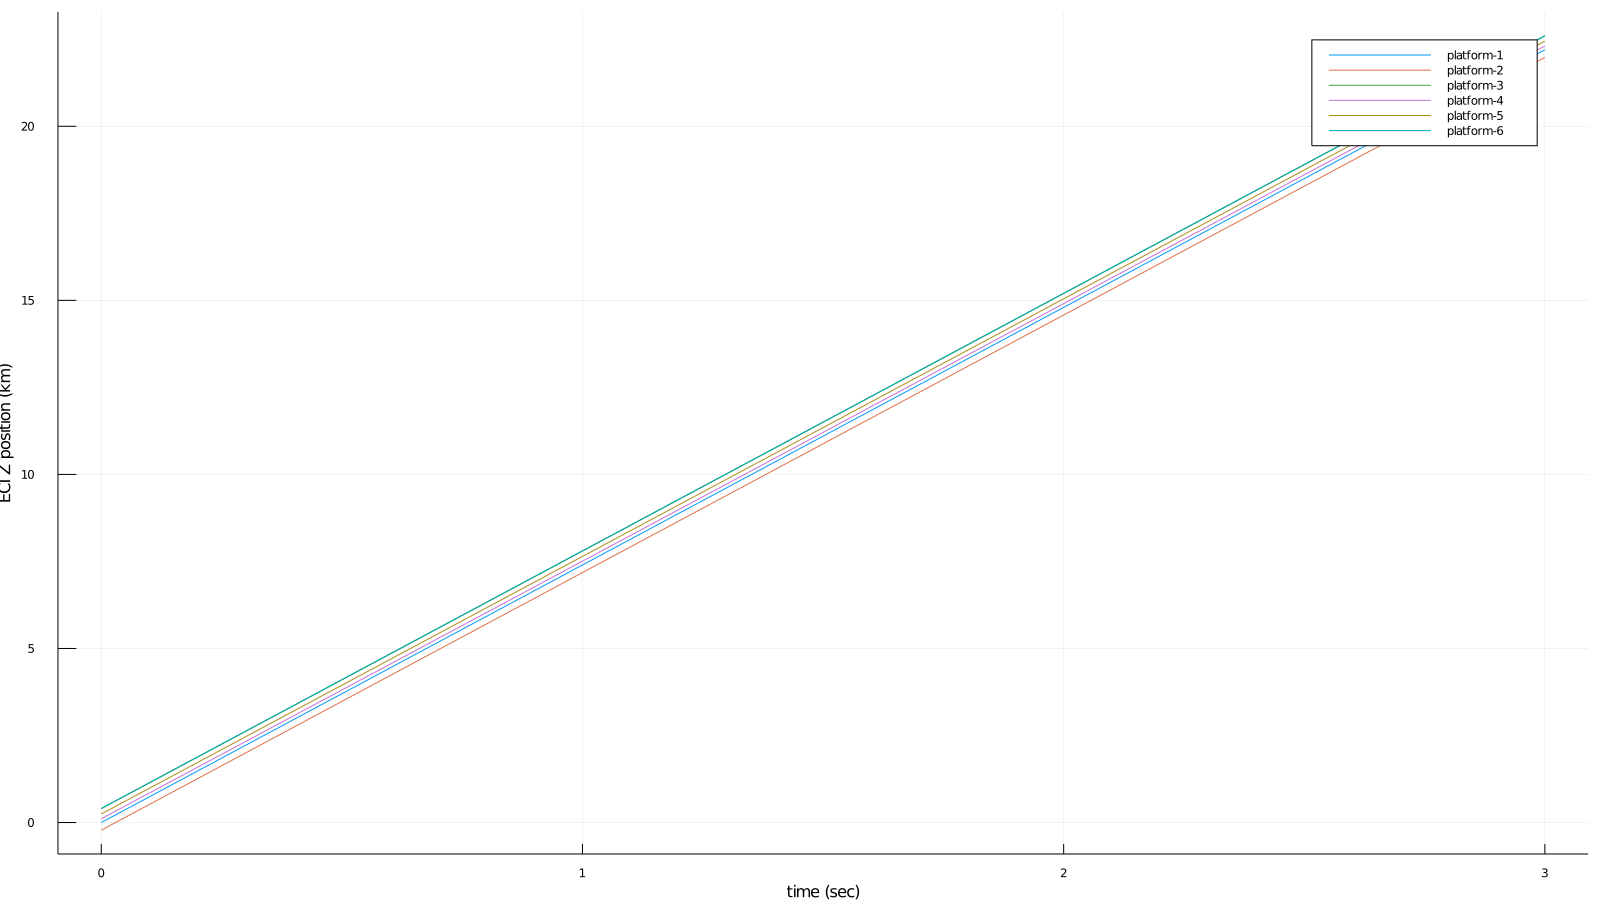

<!DOCTYPE html>
 
 
 Plots.jl

<!DOCTYPE html>
 
 
 Plots.jl

<!DOCTYPE html>
 
 
 Plots.jl

In [ ]:
if display_geometry || display_RSF_rawdata || display_tomograms!=0
    include("../modules/plotting.jl")
    if display_RSF_rawdata;Plotting.plot_RSF_rawdata(enable_fast_time,mode,ft,t_rx,MF,Srx,Np,Nst,rawdata);end
    if display_geometry;Plotting.plot_geometry(orbit_time,orbit_pos,p_xyz,t_xyz_grid,s_geo_grid,s_xyz_grid);end
    if display_tomograms!=0;Plotting.plot_tomogram(display_tomograms,image_3D,s_θ,s_ϕ,s_h,s_geo_grid,s_xyz_grid);end
end